In [88]:
import pandas as pd
import numpy as np
import torch
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm  # For progress bars
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sacrebleu.metrics import BLEU
from sacrebleu import corpus_bleu
from nltk.translate.bleu_score import corpus_bleu
import nltk
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from scipy.stats import pearsonr

In [148]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id
scaler = StandardScaler()
NUM_EPOCHS = 10

In [149]:
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [150]:
def create_input_sequences(df, numerical_columns, categorical_columns, lyrics_column):
    input_sequences = []
    for idx, row in df.iterrows():
        # Generate feature string for both numerical and categorical
        feature_string = ' '.join([f"<{col.upper()}: {row[col]:.2f}>" for col in numerical_columns] +
                                  [f"<{col.upper()}: {row[col]}>" for col in categorical_columns])

        # Concatenate the features with the lyrics
        input_sequence = f"{feature_string} <LYRICS>: {row[lyrics_column]}"
        input_sequences.append(input_sequence)
    return input_sequences

def apply_feature_weights(df, numerical_columns, feature_weights):
    for column in numerical_columns:
        if column in feature_weights:
            df[column] = df[column] * feature_weights[column]
    return df

feature_weights = {
    'tempo': 4.5,
    'valence': 4.0,
    'popularity': 4.0,
    'danceability': 3.5,
    'energy': 4.5,
    'loudness': 3.0,
    'acousticness': 3.5,
    'instrumentalness': 3.5,
    'liveness': 3.0,
    'explicit': 2.5,
    'duration_ms': 1.0,
}

## Data Parsing and Cleaning

**Here, we are opening both the training and test dataset. Some important things that are happening to note:**

- split the data into rows and then into columns, cleaning it in the process to remove the □ block character and properly separate metadata from lyrics.

- All the categorical features (artist, title, genre, and lyrics) are put into a dataframe for categorical variables

- Everything else is put into a numerical dataframe

In [151]:
train_path = 'datasets/train_data.csv'
test_path = 'datasets/test_data.csv'

df = pd.read_csv('datasets/final_lyrics_features_combined.csv')
df['explicit'] = df['explicit'].astype(int)

# Read in the CSV files
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

numerical_columns = ['duration_ms', 'popularity', 'danceability', 'energy', 'loudness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'explicit']
categorical_columns = ['Artist', 'track_genre']

# Combine train and test data to fit the LabelEncoder
combined_df = pd.concat([train_df, test_df], axis=0)

# Initialize LabelEncoder and StandardScaler
label_encoders = {}

# Process the combined dataset for label encoding
for column in categorical_columns:
    le = LabelEncoder()
    combined_df[column] = le.fit_transform(combined_df[column])
    label_encoders[column] = le

# Split combined_df back into train and test
train_df = combined_df.iloc[:train_df.shape[0]]
test_df = combined_df.iloc[train_df.shape[0]:]

# Fit and transform numerical data with StandardScaler
train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])
test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])

# Apply weights after scaling
train_df = apply_feature_weights(train_df, numerical_columns, feature_weights)
test_df = apply_feature_weights(test_df, numerical_columns, feature_weights)

# Generate structured strings
train_input_sequences = create_input_sequences(train_df, numerical_columns, categorical_columns, 'Lyrics')
test_input_sequences = create_input_sequences(test_df, numerical_columns, categorical_columns, 'Lyrics')

C:\Users\Arnav\AppData\Local\Temp\ipykernel_18700\1685657364.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])
C:\Users\Arnav\AppData\Local\Temp\ipykernel_18700\1685657364.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])
C:\Users\Arnav\AppData\Local\Temp\ipykernel_18700\993669629.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [152]:
print(test_input_sequences[0])

<DURATION_MS: 1.01> <POPULARITY: -1.05> <DANCEABILITY: -1.15> <ENERGY: 2.53> <LOUDNESS: 0.17> <ACOUSTICNESS: -2.90> <INSTRUMENTALNESS: -1.58> <LIVENESS: -1.46> <VALENCE: -4.26> <TEMPO: -0.46> <EXPLICIT: -0.88> <ARTIST: 31> <TRACK_GENRE: 6> <LYRICS>: rihanna all along it was a fever a cold sweat hotheaded believer i threw my hands in the air said show me something he said if you dare come a little closer  pre rihanna round and around and around and around we go oh now tell me now tell me now tell me now you know   rihanna not really sure how to feel about it something in the way you move makes me feel like i can't live without you and it takes me all the way i want you to stay   mikky ekko it's not much of a life you're living it's not just something you take it's given  pre mikky ekko round and around and around and around we go oh now tell me now tell me now tell me now you know   mikky ekko not really sure how to feel about it something in the way you move makes me feel like i can't 

In [153]:
# Tokenize the combined feature and lyric sequences
train_encodings = tokenizer(train_input_sequences, padding='longest', truncation=True, return_tensors="pt", max_length=512)
test_encodings = tokenizer(test_input_sequences, padding='longest', truncation=True, return_tensors="pt", max_length=512)

class LyricsFeatureDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Initialize the datasets
train_dataset = LyricsFeatureDataset(train_encodings)
test_dataset = LyricsFeatureDataset(test_encodings)

## Setting up the Model

Again, standard Hugging Face code, shouldn't need to touch, except for the **epochs**. ***Change this to increase/decrase run time when testing***

In [156]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)
# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the number of epochs
epochs = NUM_EPOCHS
num_epochs = epochs
# Initialize the optimizer
#optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)  # Adjust weight_decay as needed
optimizer = AdamW(model.parameters(), lr=5e-5)

# Calculate the total number of training steps
total_steps = len(train_loader) * epochs
# Initialize the scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # No warm-up
                                            num_training_steps=total_steps)
print(device)

cuda


# Training Loop

This is where the training occurs. We also have everything in here like the learning rate optimizer and scheduler and all that nonsense.

We also are calculating most of the metrics in here as well. This takes quite some time to run. In my experience, one epoch takes around 1 min 30 secs ish.

In [157]:
nltk.download('punkt')

# Function to calculate ROUGE scores using the rouge-score library
def calculate_rouge_scores(hypotheses, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for hyp, ref in zip(hypotheses, references):
        score = scorer.score(ref, hyp)
        scores['rouge1'].append(score['rouge1'].fmeasure)
        scores['rouge2'].append(score['rouge2'].fmeasure)
        scores['rougeL'].append(score['rougeL'].fmeasure)

    # Calculate average scores
    avg_scores = {key: sum(values) / len(values) for key, values in scores.items()}
    return avg_scores

# Initialize lists to store metrics for plotting
train_losses, val_losses, val_bleu_scores, lr_rates, val_rouge_scores = [], [], [], [], []

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Arnav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [158]:
import warnings ## supress warnings

warnings.filterwarnings("ignore", message="Setting `pad_token_id` to `eos_token_id` for open-end generation.")
warnings.filterwarnings("ignore", message="A decoder-only architecture is being used, but right-padding was detected!")

In [159]:
## TRAINING STEP with score output
all_train_losses, all_lr_rates = [], []
all_rouge1_scores, all_rouge2_scores, all_rougeL_scores = [], [], []
all_avg_val_losses = []  # Add this line before your for loop
training_time_per_epoch = []  # If you're tracking training time, initialize this list as well
all_val_bleu_scores = []

for epoch in range(epochs):
    model.train()
    train_losses, lr_rates = [], []

    for batch_idx, batch in enumerate(train_loader):  # Corrected to include batch_idx
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['input_ids'].to(device)  # Assuming you're using input_ids as labels for a language model
        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        batch_loss = loss.item()
        all_train_losses.append(batch_loss)
        all_lr_rates.append(scheduler.get_last_lr()[0])

        train_losses.append(loss.item())
        lr_rates.append(scheduler.get_last_lr()[0])
        print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Train Loss: {batch_loss:.4f}")


    # Validation Step
    model.eval()
    val_loss, hypotheses, references = 0, [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            val_loss += outputs.loss.item()

            # Generate text for BLEU and ROUGE computation
            #predictions = model.generate(input_ids, attention_mask=attention_mask, max_length=512)
            predictions = model.generate(input_ids, attention_mask=attention_mask, max_new_tokens=50)

            hyp_texts = [tokenizer.decode(g, skip_special_tokens=True) for g in predictions]
            ref_texts = [tokenizer.decode(g, skip_special_tokens=True) for g in input_ids]
            hypotheses.extend(hyp_texts)
            references.extend(ref_texts)

    avg_train_loss = np.mean(train_losses)
    avg_val_loss = val_loss / len(test_loader)
    all_avg_val_losses.append(avg_val_loss)  # Add this line after calculating avg_val_loss for each epoch
    val_bleu = corpus_bleu([[ref.split()] for ref in references], [hyp.split() for hyp in hypotheses])
    all_val_bleu_scores.append(val_bleu)  # Append the BLEU score of the current epoch to the list
    
    # For ROUGE, depending on the implementation, you might need to compute scores differently
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    val_rouge_scores = {key: [] for key in ['rouge1', 'rouge2', 'rougeL']}
    for hyp, ref in zip(hypotheses, references):
        scores = scorer.score(ref, hyp)
        for key in val_rouge_scores.keys():
            val_rouge_scores[key].append(scores[key].fmeasure)
    avg_rouge_scores = {key: np.mean(val) for key, val in val_rouge_scores.items()}
    all_rouge1_scores.append(np.mean(val_rouge_scores['rouge1']))
    all_rouge2_scores.append(np.mean(val_rouge_scores['rouge2']))
    all_rougeL_scores.append(np.mean(val_rouge_scores['rougeL']))
    print(f"Epoch {epoch+1}, Train Loss: {np.mean(train_losses)}, Validation Loss: {avg_val_loss}, Validation BLEU: {val_bleu}, Validation ROUGE: {avg_rouge_scores}")


model_save_path = './gpt2_lyrics_model_5_epochs'
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer_save_path = './gpt2_lyrics_tokenizer_5_epochs'
tokenizer.save_pretrained(tokenizer_save_path)

C:\Users\Arnav\AppData\Local\Temp\ipykernel_18700\3439358334.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 1/10, Batch 0/132, Train Loss: 4.6767
Epoch 1/10, Batch 1/132, Train Loss: 3.0884
Epoch 1/10, Batch 2/132, Train Loss: 3.0325
Epoch 1/10, Batch 3/132, Train Loss: 2.6357
Epoch 1/10, Batch 4/132, Train Loss: 2.5236
Epoch 1/10, Batch 5/132, Train Loss: 2.1961
Epoch 1/10, Batch 6/132, Train Loss: 2.0707
Epoch 1/10, Batch 7/132, Train Loss: 2.7189
Epoch 1/10, Batch 8/132, Train Loss: 2.4363
Epoch 1/10, Batch 9/132, Train Loss: 2.1792
Epoch 1/10, Batch 10/132, Train Loss: 2.0279
Epoch 1/10, Batch 11/132, Train Loss: 2.4401
Epoch 1/10, Batch 12/132, Train Loss: 2.1960
Epoch 1/10, Batch 13/132, Train Loss: 1.9048
Epoch 1/10, Batch 14/132, Train Loss: 2.4867
Epoch 1/10, Batch 15/132, Train Loss: 1.8632
Epoch 1/10, Batch 16/132, Train Loss: 2.0153
Epoch 1/10, Batch 17/132, Train Loss: 2.1429
Epoch 1/10, Batch 18/132, Train Loss: 2.3624
Epoch 1/10, Batch 19/132, Train Loss: 2.1348
Epoch 1/10, Batch 20/132, Train Loss: 1.7694
Epoch 1/10, Batch 21/132, Train Loss: 2.5965
Epoch 1/10, Batch 22

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_i

Epoch 1, Train Loss: 2.0372438484972175, Validation Loss: 1.8470265040030847, Validation BLEU: 0.9332854590696777, Validation ROUGE: {'rouge1': 0.9730205268661101, 'rouge2': 0.9729241437182148, 'rougeL': 0.9730205268661101}
Epoch 2/10, Batch 0/132, Train Loss: 1.9441
Epoch 2/10, Batch 1/132, Train Loss: 1.8609
Epoch 2/10, Batch 2/132, Train Loss: 2.0247
Epoch 2/10, Batch 3/132, Train Loss: 1.6423
Epoch 2/10, Batch 4/132, Train Loss: 1.6030
Epoch 2/10, Batch 5/132, Train Loss: 1.6774
Epoch 2/10, Batch 6/132, Train Loss: 1.7095
Epoch 2/10, Batch 7/132, Train Loss: 1.9555
Epoch 2/10, Batch 8/132, Train Loss: 1.2492
Epoch 2/10, Batch 9/132, Train Loss: 1.9034
Epoch 2/10, Batch 10/132, Train Loss: 1.9316
Epoch 2/10, Batch 11/132, Train Loss: 1.3831
Epoch 2/10, Batch 12/132, Train Loss: 1.4197
Epoch 2/10, Batch 13/132, Train Loss: 1.6994
Epoch 2/10, Batch 14/132, Train Loss: 1.8938
Epoch 2/10, Batch 15/132, Train Loss: 1.8106
Epoch 2/10, Batch 16/132, Train Loss: 1.4990
Epoch 2/10, Batch 17/

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_i

Epoch 2, Train Loss: 1.8309543457898227, Validation Loss: 1.8115792274475098, Validation BLEU: 0.9350070213162334, Validation ROUGE: {'rouge1': 0.9739698344188283, 'rouge2': 0.9739033789294692, 'rougeL': 0.9739698344188283}
Epoch 3/10, Batch 0/132, Train Loss: 1.7975
Epoch 3/10, Batch 1/132, Train Loss: 1.7322
Epoch 3/10, Batch 2/132, Train Loss: 1.8244
Epoch 3/10, Batch 3/132, Train Loss: 1.7430
Epoch 3/10, Batch 4/132, Train Loss: 1.6843
Epoch 3/10, Batch 5/132, Train Loss: 1.6457
Epoch 3/10, Batch 6/132, Train Loss: 1.4720
Epoch 3/10, Batch 7/132, Train Loss: 1.8087
Epoch 3/10, Batch 8/132, Train Loss: 2.1296
Epoch 3/10, Batch 9/132, Train Loss: 1.9616
Epoch 3/10, Batch 10/132, Train Loss: 1.6665
Epoch 3/10, Batch 11/132, Train Loss: 1.5351
Epoch 3/10, Batch 12/132, Train Loss: 1.8615
Epoch 3/10, Batch 13/132, Train Loss: 1.6853
Epoch 3/10, Batch 14/132, Train Loss: 1.3795
Epoch 3/10, Batch 15/132, Train Loss: 1.4056
Epoch 3/10, Batch 16/132, Train Loss: 2.1093
Epoch 3/10, Batch 17/

KeyboardInterrupt: 

## **Saving the Model**

Very important if you just did some huge training. This code saves both the model you just trained and the tokenizer (the code needs this to decode outputted lyrics).

You can mess with the directories however you like

In [144]:
model = GPT2LMHeadModel.from_pretrained(model_save_path)
tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_save_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [145]:
def generate_lyrics_with_features(model, tokenizer, features, device):
    """
    Generate lyrics based on structured features and a prompt.

    Args:
    - model: The trained GPT model.
    - tokenizer: The tokenizer used for the GPT model.
    - features: A dictionary containing the features and their values.
    - device: The device ('cuda' or 'cpu') to perform the computation on.

    Returns:
    - The generated lyrics as a string.
    """
    # Prepare the features string as done during training
    numerical_features = {k: v for k, v in features.items() if k in numerical_columns}
    categorical_features = {k: v for k, v in features.items() if k in categorical_columns}

    feature_string = ' '.join([f"<{key.upper()}: {value}>" for key, value in numerical_features.items()] +
                              [f"<{key.upper()}: {value}>" for key, value in categorical_features.items()])

    # Add a placeholder for the lyrics to simulate the training structure
    input_sequence = f"{feature_string} <LYRICS>:"

    # Tokenize the structured feature string
    inputs = tokenizer.encode(input_sequence, return_tensors='pt').to(device)

    # # Generate lyrics with the model
    # output_sequences = model.generate(
    #     input_ids=inputs,
    #     max_length=512,
    #     min_length=50,
    #     num_beams=5,
    #     no_repeat_ngram_size=2,
    #     early_stopping=True,
    # )
    output_sequences = model.generate(
        input_ids=inputs,
        max_length=512,
        min_length=50,
        num_beams=5,
        no_repeat_ngram_size=2,
        early_stopping=True,
        temperature=0.9,  # Adjust temperature for creativity. Higher values lead to more diverse outputs.
        top_k=50,  # Top-k sampling. Limits the next word probabilities to the top k words.
        top_p=0.92,  # Top-p (nucleus) sampling. Chooses from the top p% of the probability distribution.
        # Note: Adjust top_k, top_p, and temperature as needed to balance between creativity and coherence.
    )
    # Decode the generated sequence to a string
    lyrics = tokenizer.decode(output_sequences[0], skip_special_tokens=True)

    return lyrics

features = {
    'duration_ms': 0.59,
    'danceability': 1.28,
    'energy': 0.49,
    'loudness': -0.18,
    'acousticness': 0.51,
    'instrumentalness': 0.12,
    'liveness': 0.67,
    'valence': 0.3,
    'tempo': -0.59,
    'explicit': -0.88,
    'artist': 12,  # Note: Ensure these match the format expected by your model
    'genre': 23  # Same note as above
}

result = {}
for key in feature_weights:
    if key in features and key not in ['artist', 'genre']:
        result[key] = feature_weights[key] * features[key]

result['artist'] = features['artist']
result['genre'] = features['genre']

print(result)

generated_lyrics = generate_lyrics_with_features(model, tokenizer, result, device)
lyrics_index = generated_lyrics.find("<LYRICS>:")

final_output = generated_lyrics[lyrics_index + len("<LYRICS>:"):]
print("Generated Lyrics:\n")
print(final_output)


c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'tempo': -2.655, 'valence': 1.2, 'danceability': 4.48, 'energy': 2.205, 'loudness': -0.54, 'speechiness': 1.05, 'acousticness': 1.7850000000000001, 'instrumentalness': 0.42, 'liveness': 2.0100000000000002, 'explicit': -2.2, 'duration_ms': 0.59, 'artist': 12, 'genre': 23}
Generated Lyrics:

 i don't know what to say but i know that i'm not the only one who feels the same way  pre i've been thinking about you for a long time now and i just can't seem to find the right words to describe it all   you're my best friend i'll never let you down i love you so much i want to be with you forever but you won't let me down  post i never thought i'd say this to you but now i do it every single time i hear you say it i feel like it's my last chance to tell you what i think of you and what you mean to me i guess that's the end of the world for me now so let's just let it go and let the time run its course i promise you i will be there for you when you come back i hope you'll forgive me for the way i

In [134]:
min_value_genre = train_df['track_genre'].min()
max_value_genre = train_df['track_genre'].max()
min_value_artist = train_df['Artist'].min()
max_value_artist = train_df['Artist'].max()
temp_features = {}
for i in range(10):
    for key in features:
        if key == 'artist':
            temp_rand = np.random.randint(min_value_artist, max_value_artist)
            current_value = label_encoders['Artist'].inverse_transform([temp_rand])[0]   
        elif key == 'genre':
            temp_rand = np.random.randint(min_value_genre, max_value_genre)
            current_value = label_encoders['track_genre'].inverse_transform([temp_rand])[0]
        else:
            temp_min = train_df[key].min()
            temp_max = train_df[key].max()
            current_value = np.random.uniform(temp_min, temp_max)
        temp_features[key] = current_value
    print('GENRE: ' + temp_features['genre'] + "\n")
    generated_lyrics = generate_lyrics_with_features(model, tokenizer, temp_features, device)
    lyrics_index = generated_lyrics.find("<LYRICS>:")

    final_output = generated_lyrics[lyrics_index + len("<LYRICS>:"):]
    print("Generated Lyrics:\n")
    print(final_output)
    print("\n")

c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


GENRE: j-dance



c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Lyrics:

  I've been down so long it feel like it took me a long time to finally see you smile Disappearing in front of me Hits me like a brick shear cold Freaking out when I turn the light on   It's like the parking lot wasn't that long ago Maybe it used to be Oh, now it's all gone All I see is blood in the street as I'm trying to get to you When you turn your back on me And I can't get you out of my head Even though I try I don't know what to do  4 You take me all the way down to the bottom Fuel stinking of the sea Inside my lungs blacker than the room below Seems like everything that's wrong with me Is gonna end up in this ocean Of your lies and your plans And if you let me in on it all then I'll know  5 You drive me crazy with every breath You remind me of everything That's gone from me All these memories that I had of you And all those nights you lay awake at night With my mind all but blank  6 You never meant to leave me, never wanted me to Leave her behind But she was 

c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Lyrics:

  I've been down so long it feel like it took me a long time to get to this point It feels like my time's come and gone I can't take it anymore   How long have you been gone how long has it taken you to wake me up Is there light in your eyes Or is there nothing left to say? Can you hold on long enough to see me through this? Am I fading away from you Or am I becoming part of your past? I tried to hold you back then but you kept throwing things at me So I'll just hold my head up Hope that someday you'll come around and say that I deserve what's coming next Tell me if you can hear me when you turn your back on Aretha Franklin's heart beating slow? Or are you miles away? If so, just tell me what you think is best For me and for you And for all those who thought that we were closer Now it's too late to change it now That we're far apart And we both know that this love's never gonna be a walk in the footsteps of us All the pain and the doubt has worn away the sting And th

c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Lyrics:

 drake yeah yeah   nicki minaj yo i ain't playin' basketball i'm a man of choice my momma used to tell me that i was too young to play for the Lakers she didn't know it was the same thing to me but now it's all that she talks about  hook nicknack carry the weight for my city i don't give a fuck nigga how you expect me to feel my life is a gift from god i got that shit for low sum just to say the least bit so you can see my growth spur i made enough to last my whole life but if you look at my net worth i could buy a house in ten days and still be in school drop out of high school i can't even get a driver's license i barely speak my own language i only speak a couple of spoken words but i'll do my best to give you the best as much as i possibly can and if i end up being the only one that comes over then god damn it i gotta give it up for them to catch me i never meant to cause you trouble i just wanna see you smile in the sunshine time to set the lawnmower out for pra

c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Lyrics:

 justin bieber i've been down so long it feel like it took me forever to get to this point but i'm thankful that i finally found a way to let you know just how amazing my love has grown i can't thank you enough for all that you do for me i'll never ever be the same just tryin' hard to make it back to you when you try and break me it's gonna take a miracle to bring you back my heart will never give itself to another 'cause you're my my everything i will always love you just like i loved you before you were my enemies yeah but you showed me something i never knew could make me change my mind yeah and i know that someday when i wake up you'll be here beside me holding on to me even though i may be down maybe i should have slept a little longer but that's just the way it goes my body always tells me sleep is the only thing that keeps me up at night oh yeah my sleep has been a problem my whole life and it just ain't right tryna get up but tonight i swear to god i got the 

c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Lyrics:

 drake yeah   nicki minaj yo i ain't never had a drink in as long as i'm in the hood and i know them nigga's tryna gettin' money but they don't know me so they try to put me out the club and they talkin' shit but i never hit a uzi my whole career been on record as one of the best bitches that i've ever fucked with  hook slim shady i used to work at the record store now i work for my dad scraping the paint off the hardwood floors and my brother always tell me how i fuck with thugs so i quit school and went to law school i did it all for this shit now my main source of income is from getting approached by these rap criminals who want to take me down to the wire and then forward it to another party when i leave they'll be pissed off and left with the horseshoe instead of toggling my pajamas i guess that's how it goes with shady's ego anyways i was supposed to be a lawyer before i got sucked into this whole charade but now it's all 'cause they wanna see me go to jail and

c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\trans

Generated Lyrics:

  I've got these dreams I keep 'em all in my head And they all lead me to this Dream of gold and silver   Here I'll be, standing on a hilltop With my heart on my sleeve Watching the sunrise burn in the west As I try to picture heaven in black And white as the skyline splits in two And I can't help thinking that I'm in love with a bird that roams the sky  4 Oh, my, what a thing to have, to be happy and to dream Oh-my-Darling, you're my sweetheart I love you so, so much That I'd rather die than have to go through these things  5 Well, here I stand, holding hands with my hair Every time I think of you Is when I realize I don't have the time to hang you out to dry  6 Well-I'll-Wish-ought, well, every day I make these wishes I never knew I could do without You, always around to hear my dreams  7 Well I wish I was born with blue eyes Instead, I look out upon a bleak horizon With the dawn setting in and all the colors of my rainbow-colored hair All I see is the sun and the 

c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Lyrics:

 justin bieber i've been down so long it feel like it took me forever to get to this point but i'm thankful that i finally came this far baby i just can't wait to see you again until next time baby   jaden smith  will be available when released as the follow up to last year's hit single 'cause last time i checked i was way too young to be famous so i took it upon myself to make a name for myself and just shout out to the fans who have backed me on this ride and if you haven't yet you can still get taylor swift on the road so don't be late as i continue to grow as a person and i look forward to more from you all the way 'til the time is right  4 jayz uhhuh ahhahhh ohhuh uhuhuh yeah yeah ohhhoh yeah uhohuh ahhhhoh uh uhumuh oh yeah  interlude x ambassadors v eminem i ain't worried 'bout nothin' got nothing to hide just concentrate on me and when the night is done you've seen my face all over the world and with you i'll be your temporary home until the very last day of 

c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Lyrics:

 justin bieber i've been down so long it feel like it took me forever to get to this point but i'm thankful that i finally found a way to let you know just how amazing you are to me i can't wait to see you again until next time but if i don't get the chance to kiss you i'll miss you more than anything else i just wanna get you home and i ain't gonna lie 'bout nothin' else but you   justIN BIEBER  jaden smith and the clock points to 6 o'clock at the house where we used to live we pretend it's nothing but convenience store valet parking lot we sit on the front porch talking about our favorite drug and how it made us lose our minds pretending that it wasn't the worst thing that's happened in my life every time i think about it it just keeps me up at night and just wants to stay up all night wishing that we could get back to sleep by 7 o't fucking wake up calling you every single time that you call i wanna tell you right now  hook jadadymouthill it feels so good to meet 

In [147]:
for index, row in test_df.head(10).iterrows():
    specific_value = row['track_genre']  # Replace 'column_name' with the desired column name
    row_dict = row.to_dict()
    keys_to_remove = ['time_signature', 'track_id', 'key', 'mode']
    for key in keys_to_remove:
        row_dict.pop(key, None)

    # Rearrange keys
    # rearranged_keys = [
    #     'tempo', 'valence', 'danceability', 'popularity', 'energy', 'loudness',
    #     'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'explicit',
    #     'duration_ms', 'Artist', 'track_genre'
    # ]

    rearranged_keys = [
        'tempo', 'valence', 'danceability', 'energy', 'loudness', 'acousticness', 'instrumentalness', 'liveness', 'explicit',
        'duration_ms', 'Artist', 'track_genre'
    ]


    # Create a new dictionary with rearranged keys
    new_row_dict = {key: row_dict[key] for key in rearranged_keys}

    new_row_dict['artist'] = new_row_dict.pop('Artist')
    new_row_dict['genre'] = new_row_dict.pop('track_genre')
    print(new_row_dict)
    current_genre = label_encoders['track_genre'].inverse_transform([specific_value])[0]
    print('GENRE: ' + current_genre + "\n")
    generated_lyrics = generate_lyrics_with_features(model, tokenizer, new_row_dict, device)
    lyrics_index = generated_lyrics.find("<LYRICS>:")

    final_output = generated_lyrics[lyrics_index + len("<LYRICS>:"):]
    print("Generated Lyrics:\n")
    print(final_output)
    print("\n")


c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'tempo': -0.45619268693954723, 'valence': -4.261648923763084, 'danceability': -1.15130616093044, 'energy': 2.530760016167641, 'loudness': 0.16688671617780582, 'speechiness': -0.9597144588111134, 'acousticness': -2.8978015939958244, 'instrumentalness': -1.5777604198111708, 'liveness': -1.4583582349379733, 'explicit': -0.8843560151304032, 'duration_ms': 1.0097240893771489, 'artist': 31, 'genre': 6}
GENRE: black-metal



c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Lyrics:

 i'm so sorry i don't know what to say but i can't help but feel sorry for you  pre i just want you to know that i love you and i'll never let you down   i've been thinking about you for a long time now and it's hard to believe that you're still alive but it feels so good to see you again  post i know you'll be here forever but you won't be around forever so let me know if you want me to come back and tell you how i feel i need you so much more than anything else i could ever ask for and that's why i want to be with you forever


{'tempo': 0.4443934205651273, 'valence': 4.8651403526984085, 'danceability': 3.9537523867601814, 'energy': -0.788502440184361, 'loudness': 0.16621763781051985, 'speechiness': -1.30135862246022, 'acousticness': 4.866214692142238, 'instrumentalness': 7.164122751345259, 'liveness': -1.8660811147142917, 'explicit': -0.8843560151304032, 'duration_ms': -0.18394400056027402, 'artist': 26, 'genre': 35}
GENRE: french



c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Lyrics:

 i don't know what to say but i know that i'm not the only one who feels the same way  pre i just want you to know i love you so much i can't wait to see what you do with me   you're my best friend and i'll never let you down i promise you i won't let anyone else down  post i feel like i've never been this close to you before i see you in the mirror i want to be with you but it's too late for me to let go of you now i need you more than i ever had before so let me know if you'd like to meet me in person


{'tempo': 1.9499209794305299, 'valence': -0.9320609840169469, 'danceability': 0.6280503453185726, 'energy': -3.447481504681394, 'loudness': 1.2735423356684699, 'speechiness': -1.3374673552036214, 'acousticness': 0.6314887254102424, 'instrumentalness': -1.7700443307647187, 'liveness': 1.4572020226803923, 'explicit': -0.8843560151304032, 'duration_ms': -0.10317694164308627, 'artist': 24, 'genre': 19}
GENRE: country



c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Lyrics:

 i'm so sorry i don't know what to say but i can't help but feel sorry for you  pre i just want you to know that i love you and i'll never let you down   i've been thinking about you for a long time now and it's hard to believe that you're still alive but it feels so good to see you again  post i know you'll be fine but you won't let me down 'cause i need you more than anything else i could ever do to make it through this time and time again and all i ever wanted was to hear you say goodbye to me but that's just the way it goes i guess i should've known better than to let go of you but now i feel like i have no choice but to give it all up and leave you with me


{'tempo': -0.14765434389347779, 'valence': -0.5264259050631034, 'danceability': 1.9202020939041669, 'energy': 3.1018159226368027, 'loudness': 1.695730785425791, 'speechiness': -0.2847589159921469, 'acousticness': -2.2113746916577206, 'instrumentalness': -1.7698192178933585, 'liveness': -0.4105787673563731, '

c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Lyrics:

 i'm so sorry i don't know what to say but i can't help but feel sorry for you  pre i just want you to know that i love you and i'll never let you down   i've been thinking about you for a long time now and it's hard to believe that you're still alive but it feels so good to see you again  post i know you'll be missed but you can still be a part of my life forever so let me know if you'd like to meet me in person or on the phone i'd love to hear from you


{'tempo': -7.290605197234834, 'valence': 5.5581002792445595, 'danceability': 1.8566536472524162, 'energy': 4.011936273572028, 'loudness': 0.7282434663305668, 'speechiness': 7.1675280032806405, 'acousticness': 5.172466694723854, 'instrumentalness': -1.7349876909018462, 'liveness': 3.5755387723562366, 'explicit': -0.8843560151304032, 'duration_ms': 0.41691295046958793, 'artist': 5, 'genre': 94}
GENRE: soul



c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Lyrics:

 i don't know what to say but i know that i'm not the only one who feels the same way  pre i just want you to know i love you so much i can't wait to see what you do with me   you're my best friend and i'll never let you down i promise you i won't let anyone else down  post i feel like i've never been this close to you before i see you in the mirror i want to be with you but it's too late for me to let go of you now i need you more than i ever had before so let me know if you'd like to meet me in person


{'tempo': -2.8956782488209987, 'valence': 3.9017570401830293, 'danceability': 2.1108474338594183, 'energy': -6.1599970604099115, 'loudness': -2.034381112192379, 'speechiness': -1.35691051898853, 'acousticness': 4.200908617568383, 'instrumentalness': -1.7700443307647187, 'liveness': -1.0711353882230341, 'explicit': -0.8843560151304032, 'duration_ms': 0.13227387754191025, 'artist': 2, 'genre': 0}
GENRE: acoustic



c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Lyrics:

 i'm so sorry i don't know what to say but i can't help but feel sorry for you  pre i just want you to know that i love you and i'll never let you down   i've been thinking about you for a long time now and it's hard to believe that you're still alive but it feels so good to see you again  post i know you'll be fine but you won't let me down 'cause i need you more than anything else i could ever do to make it through this time and time again and all i ever wanted was to hear you say goodbye to me but that's not what i meant to do i guess i should've known better than to let go of you just to show you how much i mean to you i hope you feel the same way i did i promise you that we'll always be together and that if you ever need me i will be there to provide you with the things you need to feel like you've never felt before i want to give you something to hold on to so you can get back on your feet and take it all back to the way you used to be and we can always find a 

c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Lyrics:

 i don't know what to say but i know that i'm not the only one who feels the same way  pre i just want you to know i love you so much i can't wait to see what you do with me   you're my best friend and i'll never let you down i promise you i won't let anyone else down  post i feel like i've never been this close to you before i see you in the mirror i want to be with you but it's too late for me to let go i need you more than i ever have before so let me know if you'd like to meet me in person or on the phone


{'tempo': -3.4983443436695874, 'valence': 2.8707678811753414, 'danceability': 5.330635397548107, 'energy': -4.054228405304878, 'loudness': -0.057923615230213193, 'speechiness': -0.4986337176261404, 'acousticness': -2.3201469546436044, 'instrumentalness': -1.769555413747233, 'liveness': -2.9252494895522134, 'explicit': -0.8843560151304032, 'duration_ms': -1.0029378278274765, 'artist': 14, 'genre': 3}
GENRE: alternative



c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Lyrics:

 i'm so sorry i don't know what to say but i can't help but feel sorry for you  pre i just want you to know that i love you and i'll never let you down   i've been thinking about you for a long time now and it's hard to believe that you're still alive but it feels so good to see you again  post i know you'll be here forever but you won't be around forever so let me know if you want me to come back and tell you how i feel i need you so much more than anything else i could ever ask for and that's why i want to be with you forever


{'tempo': -2.1526985023904954, 'valence': -6.130950579275384, 'danceability': -8.988947914646332, 'energy': -6.677516475647588, 'loudness': -2.291307205230114, 'speechiness': -1.2041428035356774, 'acousticness': -2.72461080632898, 'instrumentalness': -0.687861100215177, 'liveness': -2.594971179118883, 'explicit': -0.8843560151304032, 'duration_ms': 0.3486780162771193, 'artist': 11, 'genre': 35}
GENRE: french



c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Arnav\Documents\Coding Projects\CS 224N\.venv\lib\site-packages\transformers\generation\configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Lyrics:

 i'm so sorry i don't know what to say but i can't help but feel sorry for you  pre i just want you to know that i love you and i'll never let you down   i've been thinking about you for a long time now and it's hard to believe that you're still alive but it feels so good to see you again  post i know you'll be fine but you won't let me down 'cause i need you more than anything else i could ever do to make it through this time and if i ever feel the need to leave you i'd rather you stay with me than leave me alone with you so that we can spend the rest of our lives together


{'tempo': 5.305161692230918, 'valence': -0.10388936448618206, 'danceability': -4.667653542327301, 'energy': 5.510958028053576, 'loudness': 2.921482354293322, 'speechiness': 4.251053435544366, 'acousticness': -3.0437465138467874, 'instrumentalness': -1.7700443307647187, 'liveness': -1.0939132027356775, 'explicit': -0.8843560151304032, 'duration_ms': -0.1699074835856422, 'artist': 11, 'genre': 43}

## Testing

Now we open the model you just saved, and load it up for testing/lyric generation.

# Visualization

**Summary of Training Metrics**

In [116]:
def summarize_training_performance(all_train_losses, all_lr_rates, all_rouge1_scores, all_rouge2_scores, all_rougeL_scores, val_bleu, epochs):
    # Calculate average training loss
    avg_train_loss = np.mean(all_train_losses)

    # Identify the lowest and final training loss
    lowest_train_loss = min(all_train_losses)
    final_train_loss = all_train_losses[-1]

    # Summarize Learning Rate
    initial_lr = all_lr_rates[0]
    final_lr = all_lr_rates[-1]

    # Calculate average ROUGE scores over all epochs
    avg_rouge1 = np.mean(all_rouge1_scores)
    avg_rouge2 = np.mean(all_rouge2_scores)
    avg_rougeL = np.mean(all_rougeL_scores)

    # Print the summary
    print(f"Training Summary Over {epochs} Epochs:")
    print(f"- Average Training Loss: {avg_train_loss:.4f}")
    print(f"- Lowest Training Loss: {lowest_train_loss:.4f}")
    print(f"- Final Training Loss: {final_train_loss:.4f}")
    print(f"- Learning Rate Started at {initial_lr} and Ended at {final_lr}")
    print(f"- Validation BLEU Score: {val_bleu:.4f}")
    print(f"- Average ROUGE-1 Score: {avg_rouge1:.4f}")
    print(f"- Average ROUGE-2 Score: {avg_rouge2:.4f}")
    print(f"- Average ROUGE-L Score: {avg_rougeL:.4f}")


# Example usage
summarize_training_performance(all_train_losses, all_lr_rates, all_rouge1_scores, all_rouge2_scores, all_rougeL_scores, val_bleu, epochs)


Training Summary Over 50 Epochs:
- Average Training Loss: 1.1631
- Lowest Training Loss: 0.4393
- Final Training Loss: 0.7515
- Learning Rate Started at 4.999242424242424e-05 and Ended at 0.0
- Validation BLEU Score: 0.9400
- Average ROUGE-1 Score: 0.9752
- Average ROUGE-2 Score: 0.9752
- Average ROUGE-L Score: 0.9752


Training Loss Improvement: 82.07% over 50 epochs.
ROUGE-1 Score Improvement: 0.33%
ROUGE-2 Score Improvement: 0.34%
ROUGE-L Score Improvement: 0.33%
Validation BLEU Score by the end of training: 0.9400
Decreasing learning rate correlates with improved loss, suggesting effective learning rate scheduling.


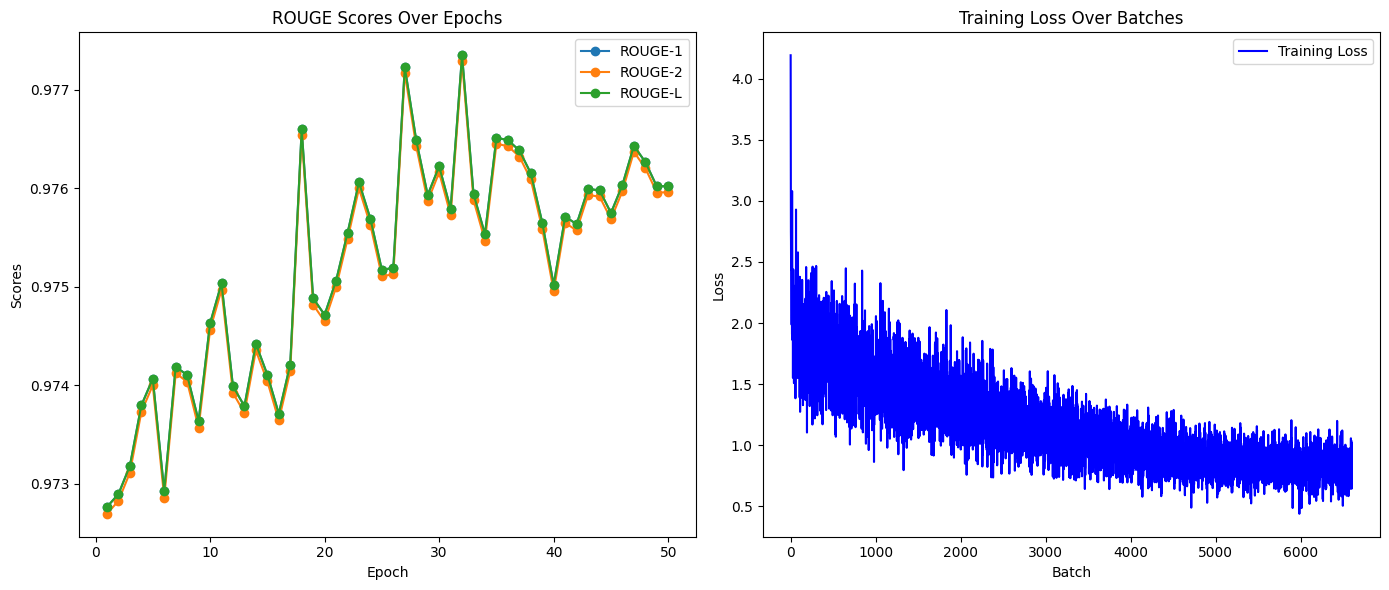

Modest improvement in ROUGE-1 may indicate the need for longer training or model adjustments.


In [117]:
def analyze_model_performance(all_train_losses, all_lr_rates, all_rouge1_scores, all_rouge2_scores, all_rougeL_scores, val_bleu, epochs):
    # Trend Analysis for Training Loss
    loss_improvement = (all_train_losses[0] - all_train_losses[-1]) / all_train_losses[0]
    print(f"Training Loss Improvement: {loss_improvement * 100:.2f}% over {epochs} epochs.")

    # Analyzing BLEU and ROUGE Scores Improvement
    rouge1_improvement = (all_rouge1_scores[-1] - all_rouge1_scores[0]) / max(1e-5, all_rouge1_scores[0])
    rouge2_improvement = (all_rouge2_scores[-1] - all_rouge2_scores[0]) / max(1e-5, all_rouge2_scores[0])
    rougeL_improvement = (all_rougeL_scores[-1] - all_rougeL_scores[0]) / max(1e-5, all_rougeL_scores[0])

    print(f"ROUGE-1 Score Improvement: {rouge1_improvement * 100:.2f}%")
    print(f"ROUGE-2 Score Improvement: {rouge2_improvement * 100:.2f}%")
    print(f"ROUGE-L Score Improvement: {rougeL_improvement * 100:.2f}%")
    print(f"Validation BLEU Score by the end of training: {val_bleu:.4f}")

    # Learning Rate Efficiency
    if loss_improvement > 0 and np.mean(all_lr_rates[-(epochs//4):]) < np.mean(all_lr_rates[:epochs//4]):
        print("Decreasing learning rate correlates with improved loss, suggesting effective learning rate scheduling.")
    else:
        print("Consider reviewing learning rate schedule. Improvements in loss may not correlate well with learning rate adjustments.")

    # Plotting the Analysis for Visual Inspection
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, all_rouge1_scores, label='ROUGE-1', marker='o')
    plt.plot(epochs_range, all_rouge2_scores, label='ROUGE-2', marker='o')
    plt.plot(epochs_range, all_rougeL_scores, label='ROUGE-L', marker='o')
    plt.title('ROUGE Scores Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Scores')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(all_train_losses, label='Training Loss', color='blue')
    plt.title('Training Loss Over Batches')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Insights based on improvement rates
    if rouge1_improvement > 0.1:
        print("Significant improvement in ROUGE-1 suggests good learning in capturing key information from the reference texts.")
    else:
        print("Modest improvement in ROUGE-1 may indicate the need for longer training or model adjustments.")

# Example usage of the function
analyze_model_performance(all_train_losses, all_lr_rates, all_rouge1_scores, all_rouge2_scores, all_rougeL_scores, val_bleu, epochs)


In [118]:
def evaluate_advanced_metrics_fixed(all_train_losses, all_avg_val_losses, all_lr_rates, all_rouge1_scores, epochs, training_time_per_epoch):
    # Assuming all_train_losses contains batch losses for every epoch and needs to be averaged per epoch
    batches_per_epoch = len(all_train_losses) // epochs
    avg_train_losses_per_epoch = [np.mean(all_train_losses[i * batches_per_epoch:(i + 1) * batches_per_epoch]) for i in range(epochs)]

    # Stability Over Time for ROUGE-1
    rouge1_stability = np.std(all_rouge1_scores[-3:])  # Last 3 epochs
    print(f"ROUGE-1 Stability (last 3 epochs): {rouge1_stability:.4f}")

    # Skip Pearson correlation due to potential mismatch in lengths or revisit with aligned data

    # Overfitting Detection by comparing average training and validation losses per epoch
    if len(all_avg_val_losses) == len(avg_train_losses_per_epoch):
        overfitting_indicator = np.array(all_avg_val_losses) - np.array(avg_train_losses_per_epoch)
        overfit_indicator_avg_last_3 = np.mean(overfitting_indicator[-3:])
        print(f"Overfitting Indicator (avg. of last 3 epochs): {overfit_indicator_avg_last_3:.4f}")
    else:
        print("Mismatch in length between average validation losses and calculated average training losses per epoch.")

    # Efficiency Analysis - if you track training time
    # Include efficiency analysis here based on your specific setup

    # Further plotting and analysis as before, adjusted for fixed lengths

# Example call with adjustments (ensure you have defined/collected all necessary parameters)
evaluate_advanced_metrics_fixed(
    all_train_losses=all_train_losses,
    all_avg_val_losses=all_avg_val_losses,  # This should be your list of avg validation losses per epoch
    all_lr_rates=all_lr_rates,
    all_rouge1_scores=all_rouge1_scores,
    epochs=epochs,
    training_time_per_epoch=[3600] * epochs  # Example placeholder
)


ROUGE-1 Stability (last 3 epochs): 0.0001
Overfitting Indicator (avg. of last 3 epochs): 1.5049


**Training Loss Visualzation**

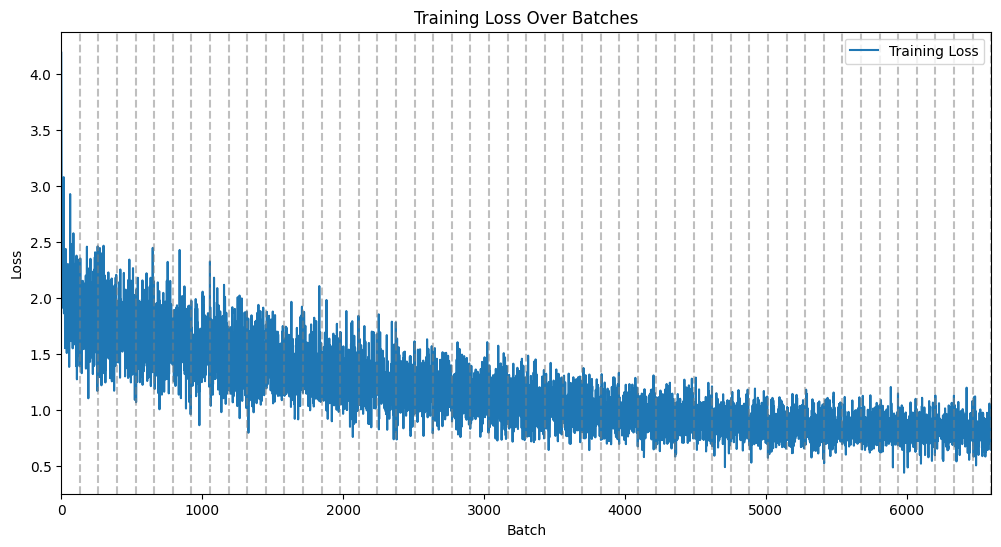

In [119]:
batches_per_epoch = 132
total_batches = batches_per_epoch * epochs

plt.figure(figsize=(12, 6))
plt.plot(all_train_losses, label='Training Loss')

# Adding vertical lines at the start of each epoch
for epoch in range(1, epochs + 1):
    plt.axvline(x=epoch * batches_per_epoch, color='grey', linestyle='--', alpha=0.5)

plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss Over Batches')
plt.legend()
plt.xlim(0, total_batches)
plt.show()

**ROUGE Score Visualzation**

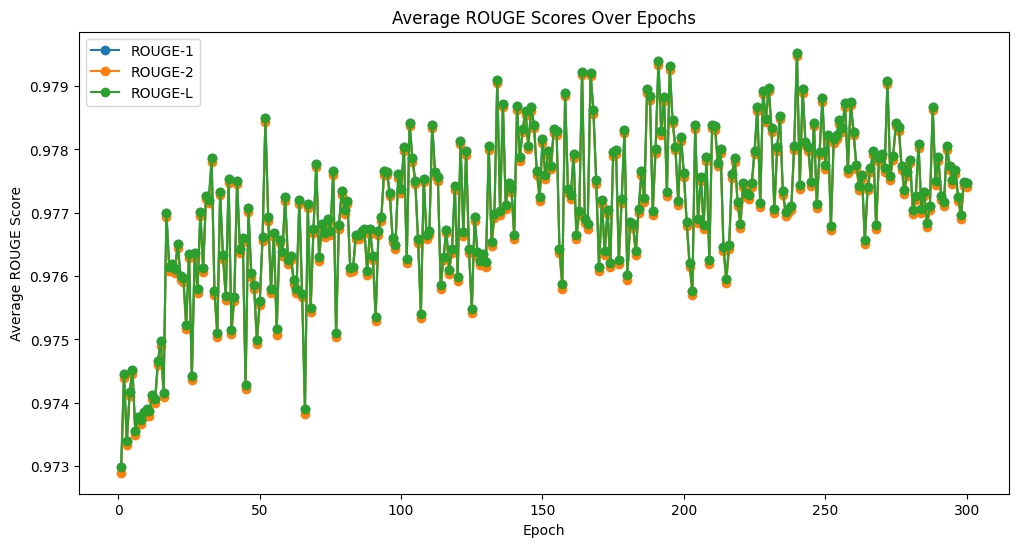

In [83]:
# Use the length of one of the ROUGE score lists to determine the number of epochs actually run
epochs_range = range(1, len(all_rouge1_scores) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_range, all_rouge1_scores, label='ROUGE-1', marker='o')
plt.plot(epochs_range, all_rouge2_scores, label='ROUGE-2', marker='o')
plt.plot(epochs_range, all_rougeL_scores, label='ROUGE-L', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Average ROUGE Score')
plt.title('Average ROUGE Scores Over Epochs')
plt.legend()
plt.show()


**Learning Rate Visualzation**

C:\Users\Arnav\AppData\Local\Temp\ipykernel_18700\1219532976.py:3: RuntimeWarning: divide by zero encountered in log
  all_lr_rates_log = np.log(all_lr_rates)


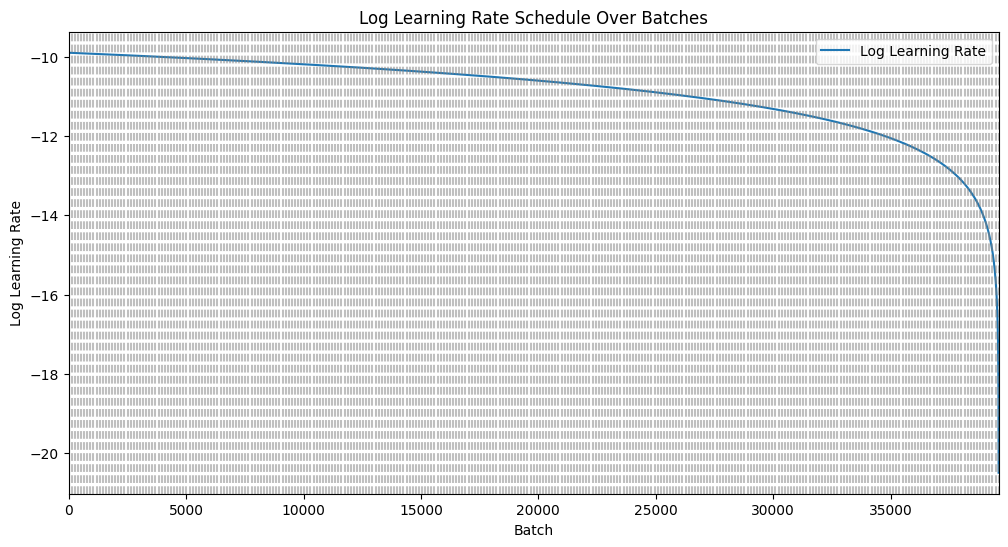

In [84]:
total_batches = batches_per_epoch * epochs

all_lr_rates_log = np.log(all_lr_rates)

# Plot Learning Rate Schedule Over Batches with Epoch Indicators
plt.figure(figsize=(12, 6))
plt.plot(all_lr_rates_log, label='Log Learning Rate')

# Adding vertical lines at the start of each epoch
for epoch in range(1, epochs + 1):
    plt.axvline(x=epoch * batches_per_epoch, color='grey', linestyle='--', alpha=0.5)

plt.xlabel('Batch')
plt.ylabel('Log Learning Rate')
plt.title('Log Learning Rate Schedule Over Batches')
plt.legend()
plt.xlim(0, total_batches)  # Set the x-axis limit to the total number of batches
plt.show()

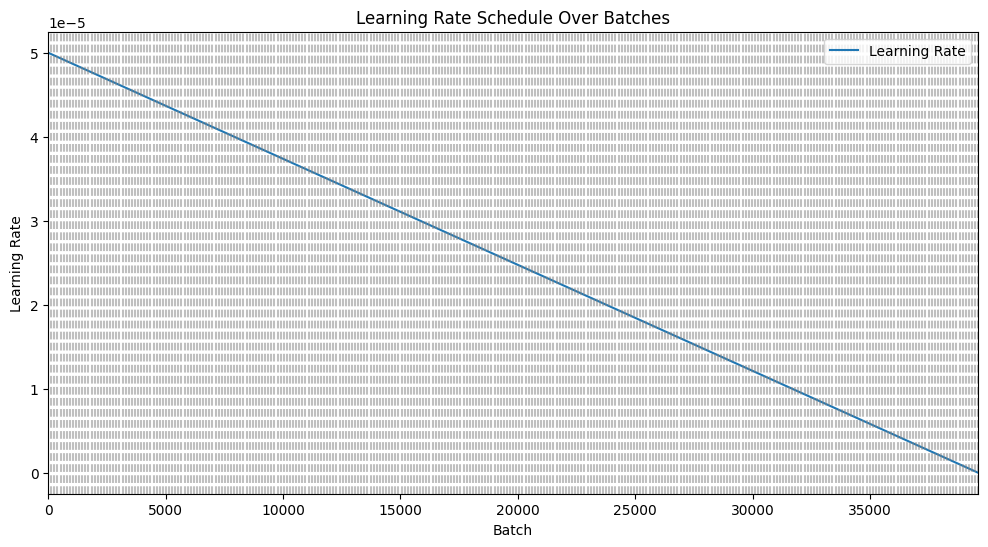

In [85]:
total_batches = batches_per_epoch * epochs

# Plot Learning Rate Schedule Over Batches with Epoch Indicators
plt.figure(figsize=(12, 6))
plt.plot(all_lr_rates, label='Learning Rate')

# Adding vertical lines at the start of each epoch
for epoch in range(1, epochs + 1):
    plt.axvline(x=epoch * batches_per_epoch, color='grey', linestyle='--', alpha=0.5)

plt.xlabel('Batch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule Over Batches')
plt.legend()
plt.xlim(0, total_batches)  # Set the x-axis limit to the total number of batches
plt.show()

**BLEU Score Visualization** 

In [120]:
epochs = list(range(1, len(bleu_scores) + 1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, bleu_scores, marker='o', linestyle='-', color='b')
plt.title('BLEU Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(ticks=epochs[::5], labels=epochs[::5])  # Show every 5th epoch
plt.tight_layout()

# Save the plot to a file
plt.savefig('/mnt/data/bleu_scores_over_epochs.png')
plt.show()

NameError: name 'bleu_scores' is not defined